# Calculating the distance covered by the larvae

Some information required:
* The x-axis was labeled and recorded as A to P
* The y-axis went from top to bottom, and has values from 1 to 16

## Setting up the project

We need to import some external libraries to process our data and generate our plots.

In [1]:
import csv
import math

from collections import namedtuple
from typing import List
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Allows us define a variable as being a Point(x, y), denoting a 2D point in space
Point = namedtuple('Point', ['x', 'y'])

## Loading and saving data

We want to read in our data as a csv file, and after we've done the necessary processing we want to store it back as a csv file

In [136]:
NR_OF_SAMPLE_POINTS = 19
NR_OF_MEASUREMENTS = 3

def load_data(file_name:str):
    with open(file_name) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        total = 0
        skipped = 0
        for row in reader:
            total +=1
            if '' in row:
#                 print(f"Empty row: {row}")
                skipped += 1
                continue
            
            larva_id = row[0]
#             print(f"row length: {len(row)}, {row}")
            
#             print([larva_id] + row[1:20])
            yield [larva_id] + row[1:20]
            
            if len(row) > 20:
#                 print([larva_id] + row[20:39])
                yield [larva_id] + row[20:39]
                
            if len(row) > 40:
#                 print([larva_id] + row[39:58])
                yield [larva_id] + row[39:58]

    print(f"Loaded a total of {total} rows, skipped {skipped} rows")
            
def write_data(file_name:str, data):
    with open(file_name, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["id", "distance", "nr of squares","distance", "nr of squares","distance", "nr of squares"])
        for entry in data:
            print(entry)
            writer.writerow(entry)

## Converting coordinate format

It's a bit easier to reason about coordinates when they're in a regular (x, y) format. So we convert coordinates from, for example, A3, to (0, 2), with the upper left being (0,0) and the bottom right being (15,15). This also makes it easier to plot the data if we want to.

In [3]:
def convert_to_point(coordinate: str) -> Point:
    return Point(ord(coordinate[0].lower()) - ord('a'), int(coordinate[1:]) - 1)

assert convert_to_point("A1") == Point(0, 0)
assert convert_to_point("P16") == Point(15, 15)

## Calculating the distance between two points

Using pythagoras

In [4]:
def distance(a: Point, b:Point) -> float:
    return math.sqrt((b.x - a.x)**2 + (b.y - a.y)**2)

a = Point(0, 0)
b = Point(1, 0)
assert distance(a, b) == 1

b = Point(0, 1)
assert distance(a, b) == 1

b = Point(1, 1)
assert distance(a, b) == math.sqrt(2) #pythagoras: a^2 + b^2 = c^2

## Process our raw data

In [67]:
def process_data(individuals):
    results = {}
    
    for individual in individuals:
        id = individual[0]
        coordinates = individual[1:]
        
        result = process_individual(coordinates)
        results[id] = results.get(id, []) + [result[0], result[1]]
        
    return results

def process_individual(coordinates: List):
    coordinates = list(map(convert_to_point, coordinates))
    unique_coordinates = set(coordinates)
    total_distance = 0
    for i in range(1, len(coordinates)):
        total_distance += distance(coordinates[i-1], coordinates[i])
    
    return total_distance, len(unique_coordinates)
#     print(f"Individual {id}: total distance: {total_distance}, squares visited: {len(unique_coordinates)}")

In [148]:
data = load_data("data-thesis-final.csv")
results = process_data(data)

formatted_results = []

for i in range(1, 105):
    if str(i) in results:
        formatted_results.append([i] + results[str(i)])
    else:
        formatted_results.append([i] + ['','','','','',''])

# for key in results:
#     formatted_results.append([key] + results[key])
    
write_data("results.csv", formatted_results)

Loaded a total of 104 rows, skipped 27 rows
[1, 11.838393244542416, 4, 49.70110262113829, 7, 50.35503682799604, 7]
[2, 30.0, 3, 123.41193805599048, 12, 112.61697998915356, 12]
[3, 5.650281539872885, 4, 81.40292684792065, 8, 163.1454553392119, 16]
[4, '', '', '', '', '', '']
[5, 5.47213595499958, 3, 82.96410498906609, 13, 118.71002883385053, 12]
[6, 10.23606797749979, 3, 83.37944475829148, 12, 105.59900181858083, 12]
[7, 0.0, 1, 184.11139343413134, 18, 162.21529650507733, 19]
[8, 18.558873956203158, 3, 8.576491222541474, 4, 106.99583192001604, 10]
[9, 0.0, 1, 168.81696800666475, 17, 160.70865697653397, 16]
[10, 5.06449510224598, 3, 119.85975948687918, 15, 166.80504997657144, 17]
[11, 7.0, 2, 189.75668435776754, 15, 127.53416855992481, 14]
[12, '', '', '', '', '', '']
[13, 4.23606797749979, 3, 29.08889358515468, 7, 187.40542819561372, 16]
[14, 21.307766542143632, 5, 133.26297555848623, 16, 134.50380334153724, 15]
[15, '', '', '', '', '', '']
[16, 1.4142135623730951, 2, 173.47112556771998

## Generating a heatmap of locations

In [121]:
def generate_heatmap(individuals) -> List[List[int]]:
    heatmap_data = [ # TODO: pre-populate this list in a better way
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]

    for individual in individuals:
        coordinates = list(map(convert_to_point, individual[1:]))
        for coordinate in coordinates:
            heatmap_data[coordinate.y][coordinate.x] = heatmap_data[coordinate.y][coordinate.x] + 1

    return heatmap_data
    

Loaded a total of 104 rows, skipped 27 rows


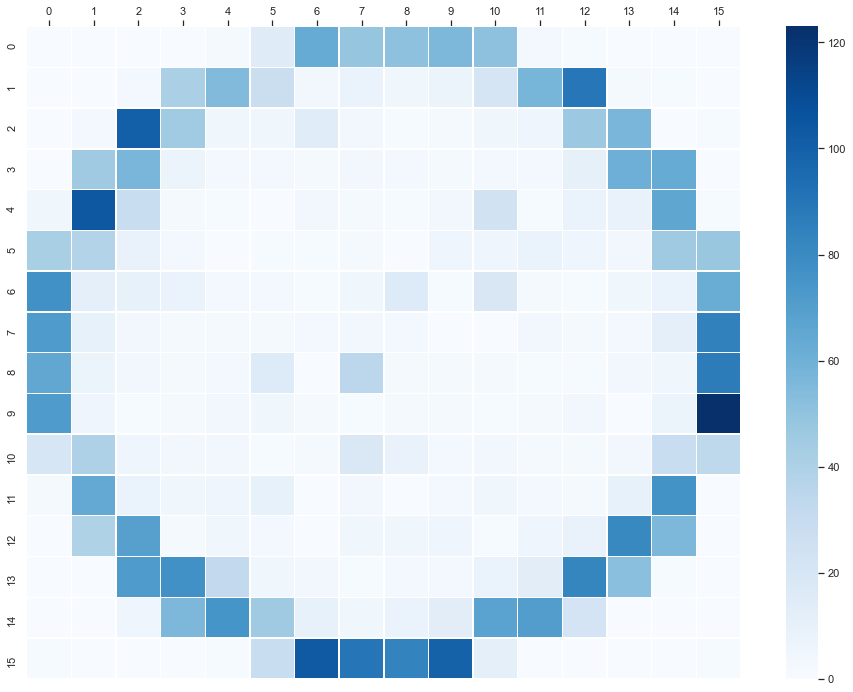

In [178]:
Z = [ # to be used to debug the generated heatmap
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

sns.set_theme()

data = load_data("data-thesis-final.csv")
heatmap = generate_heatmap(data)

fig, ax = plt.subplots(figsize=(16,12))  
ax = sns.heatmap(heatmap, cmap="Blues", ax=ax,  linewidths=.5)
ax.xaxis.tick_top()

fig.savefig("plot.png", transparent=True)
